## showing effect of pcs or peers on long range correlations
for both PEER factors and global PCs
* longer range chromosome correlations being removed with more pcs or peers (boxplot by gene distance decile)
* visualizations of across chr corr structure as pcs or peers are removed
    * with outlining of clusters
* line graph showing fraction of short vs long corrs that are signifigant

In [2]:
# import packages
import numpy as np
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import spearmanr, linregress
import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
import scipy as sp
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA

from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()



from residualize import calculate_residual

In [24]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/tami_clusters/proteincoding.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']
covariates_dir = config['covariates_dir']

tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
tissue_id = 'Cells_Cultured_fibroblasts'

### load in data

expression and covariates

In [25]:
expression_df_full = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')
covariates_df = pd.read_csv(f'{prefix}/{covariates_dir}/{tissue_id}.v8.covariates.txt', sep='\t', index_col=0).T
# make sure the genes are in the same order in both
expression_df = expression_df_full.set_index('gene_id')[covariates_df.index]

In [26]:
# load in the gene information (for gene-gene distances)
full_gencode=pd.read_csv(f'{prefix}/data/references/processed_gencode.v26.GRCh38.genes.csv')


gid_gencode = full_gencode.set_index('transcript_id').loc[expression_df.index]
gid_gencode = gid_gencode.drop_duplicates()

In [27]:
# function to residualize expression based on two covariate dfs
def two_part_residualize(expression_df, base_covariates_df, additional_covariates_df):
    full_covariates = pd.concat([base_covariates_df, additional_covariates_df], axis=1)
    # residulize the expression 
    residal_exp = calculate_residual(expression_df[full_covariates.index], full_covariates, center=True)
    residal_exp = pd.DataFrame(residal_exp, columns=full_covariates.index, index=expression_df.index)
    return residal_exp

In [28]:
# split out covatiates
base_covariates_df = covariates_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'pcr', 'platform', 'sex']]
peer_covariates_df = covariates_df[[f'InferredCov{i}' for i in range(1,61,1)]]

In [29]:
# get the genes to plot
chr_num = 21

selected_chr_gene_ids = gid_gencode[gid_gencode['chr'] == f'chr{chr_num}'].index.values
selected_chr_gene_names = gid_gencode[gid_gencode['chr'] == f'chr{chr_num}']['gene_name']

## peers

* boxplot by gene distance decile
* heatmap of correlation
    * with cluster outlines

In [30]:
# by decile of gene-gene distance

# matrix of gene-gene distances
start_positions = gid_gencode.loc[selected_chr_gene_ids]['tss_start'].values
dist_matrix = np.abs(start_positions[:, None] - start_positions)

# Create deciles based on distance 
deciles = np.percentile(dist_matrix, [10, 20, 30, 40, 50, 60, 70, 80, 90])
decile_df = pd.DataFrame(np.digitize(dist_matrix, deciles), index=selected_chr_gene_ids, columns=selected_chr_gene_ids)

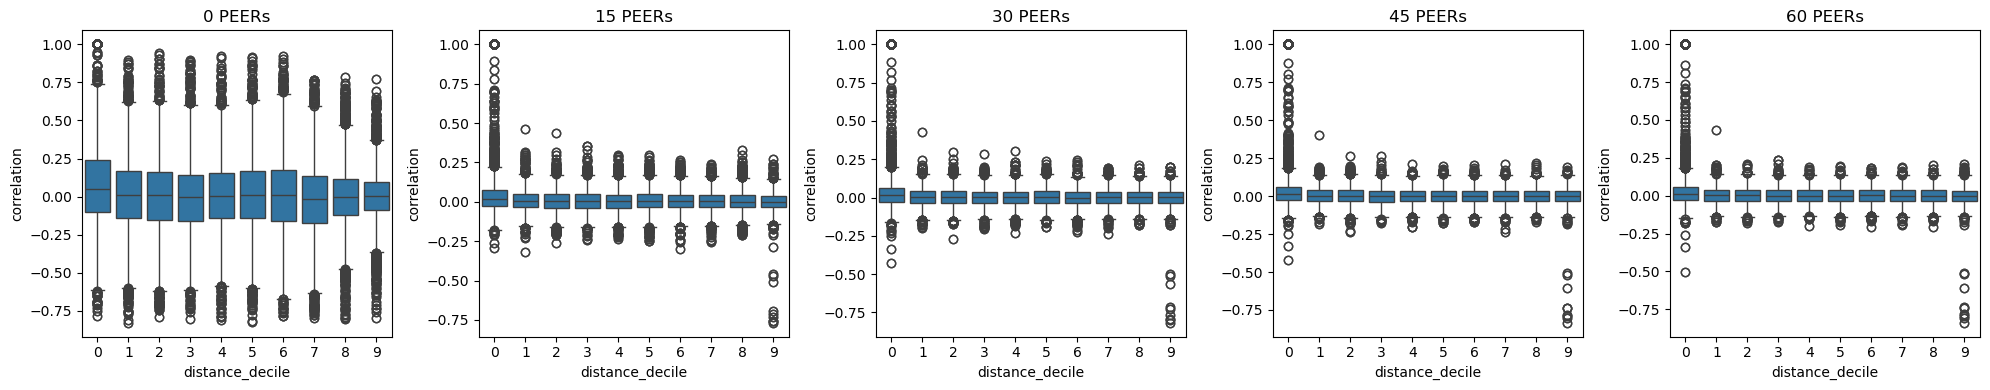

In [31]:
# boxplots plots by increaseing peer factor count

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axes[i].set_title(f'{15*i} PEERs')

    # get corr with this many peerspeer_covariates_df
    sub_exp = two_part_residualize(expression_df, base_covariates_df, peer_covariates_df.iloc[:, :15*i])
    sub_corr = sub_exp.loc[selected_chr_gene_ids].T.corr(method='spearman')
    distance_split_corr_df = pd.DataFrame([pd.Series(sub_corr.values[decile_df==i], name=i) for i in range(10)]).T.melt(var_name='distance_decile', value_name='correlation')
    sns.boxplot(distance_split_corr_df, y='correlation', x='distance_decile', ax=axes[i])

fig.tight_layout()

In [32]:
# what are the far away strong negative corr genes?
long_distance_neg_filter = np.where((decile_df==9) & (sub_corr < -.3))

# Iterating over these indices and printing the corresponding gene indices
for row,col in zip(*long_distance_neg_filter):
    print(f"Gene 1: {selected_chr_gene_ids[row]}, Gene 2: {selected_chr_gene_ids[col]}")

# all of these are paralogs with one another


Gene 1: ENSG00000280071.3, Gene 2: ENSG00000241945.7
Gene 1: ENSG00000280071.3, Gene 2: ENSG00000160221.16
Gene 1: ENSG00000275464.4, Gene 2: ENSG00000241945.7
Gene 1: ENSG00000275464.4, Gene 2: ENSG00000160221.16
Gene 1: ENSG00000280433.1, Gene 2: ENSG00000241945.7
Gene 1: ENSG00000280433.1, Gene 2: ENSG00000160221.16
Gene 1: ENSG00000275993.2, Gene 2: ENSG00000142178.7
Gene 1: ENSG00000274276.4, Gene 2: ENSG00000160200.17
Gene 1: ENSG00000275895.6, Gene 2: ENSG00000160201.11
Gene 1: ENSG00000160200.17, Gene 2: ENSG00000274276.4
Gene 1: ENSG00000160201.11, Gene 2: ENSG00000275895.6
Gene 1: ENSG00000142178.7, Gene 2: ENSG00000275993.2
Gene 1: ENSG00000241945.7, Gene 2: ENSG00000280071.3
Gene 1: ENSG00000241945.7, Gene 2: ENSG00000275464.4
Gene 1: ENSG00000241945.7, Gene 2: ENSG00000280433.1
Gene 1: ENSG00000160221.16, Gene 2: ENSG00000280071.3
Gene 1: ENSG00000160221.16, Gene 2: ENSG00000275464.4
Gene 1: ENSG00000160221.16, Gene 2: ENSG00000280433.1


In [92]:
cross_mapp_agg = pd.read_csv(f'{prefix}/data/references/cross_mappability/cross_mappability_100_agg.csv')

# df to give yes/no if cross mappable
cross_map_df = pd.DataFrame(False, index=selected_chr_gene_ids, columns=selected_chr_gene_ids)

for idx, row in tqdm(cross_map_df.iterrows(), total=cross_map_df.shape[0]):
    try:
        cross_map_ids = cross_mapp_agg.loc[idx]
    except KeyError:
        cross_map_ids = []
    cross_map_df.loc[idx] = row.index.isin(cross_map_ids)

  0%|          | 0/243 [00:00<?, ?it/s]

In [94]:
print('{}/{} pairs are cross mappable'.format(cross_map_df.values.sum(), len(cross_map_df.values.flatten())))

50/59049 pairs are cross mappable


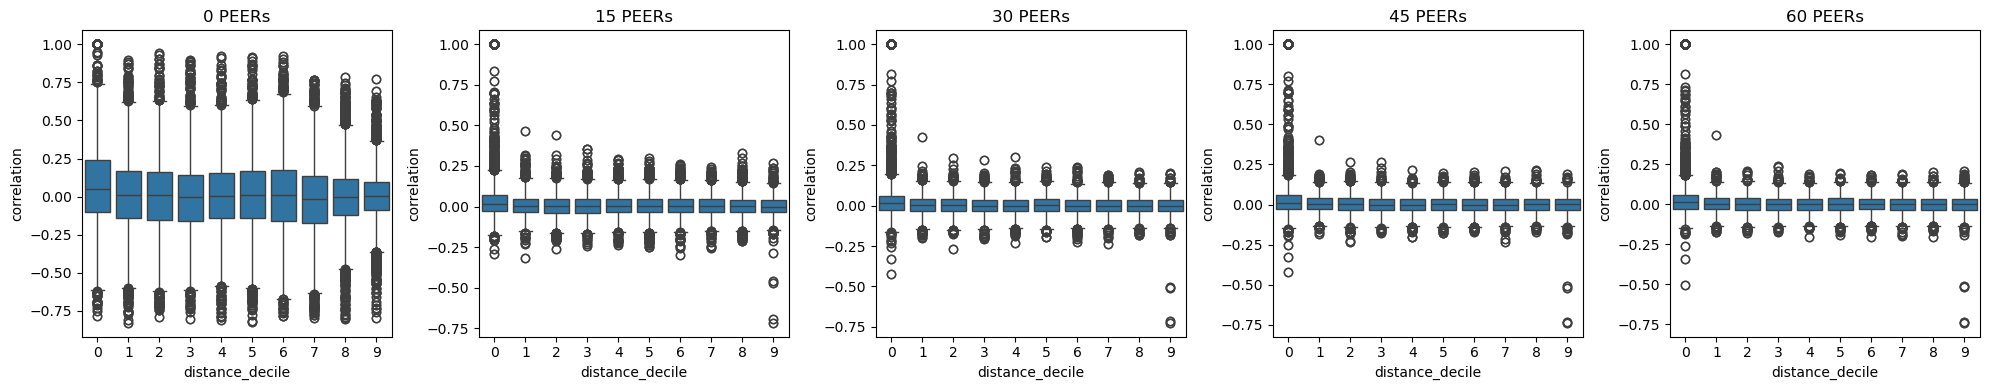

In [68]:
# boxplots plots by increaseing peer factor count, excluding cross mappable

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axes[i].set_title(f'{15*i} PEERs')

    # get corr with this many peerspeer_covariates_df
    sub_exp = two_part_residualize(expression_df, base_covariates_df, peer_covariates_df.iloc[:, :15*i])
    sub_corr = sub_exp.loc[selected_chr_gene_ids].T.corr(method='spearman')
    distance_split_corr_df = pd.DataFrame([pd.Series(sub_corr.values[(decile_df==i)&(cross_map_df==False)], name=i) for i in range(10)]).T.melt(var_name='distance_decile', value_name='correlation')
    sns.boxplot(distance_split_corr_df, y='correlation', x='distance_decile', ax=axes[i])

fig.tight_layout()

In [69]:
def plot_heatmap_corr(corr, ax, cbar=True, tick_labels=False):
    # plot a heat map of correlations for increasing number of peer factors

    # mask so the off diagonal isn't shown
    mask = np.triu(np.ones_like(corr)) 
    # create the colormap, these are colors matched to the manhattenplots. coolwarm is another good option
    cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#c4553aff'), (.5, 'white'), (1, '#3e8093ff')])
    # plot the correlations
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, ax=ax, cbar_kws={'label':'Spearman Corrleation', 'pad':0}, xticklabels=True, yticklabels=True, cbar=cbar)

    if not tick_labels:
        ax.tick_params(left=False, bottom=False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # no axis labels
    ax.set_ylabel('')
    ax.set_xlabel('')

    return ax

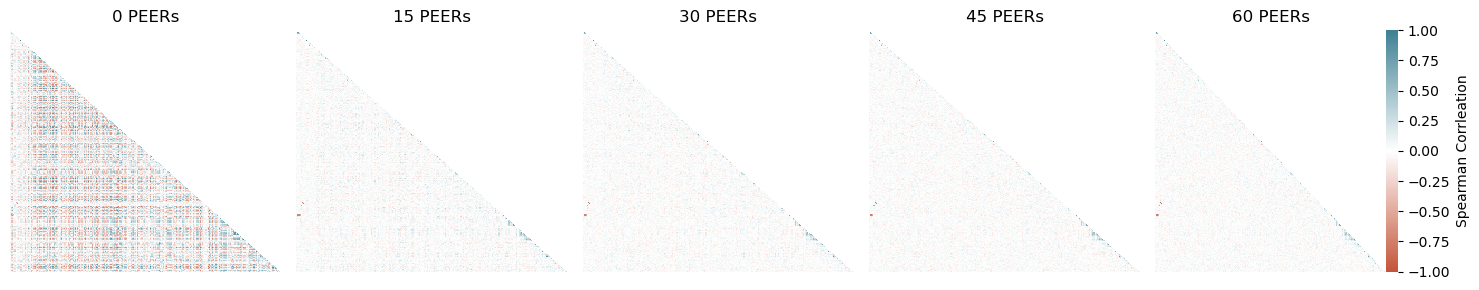

In [70]:
# correlation plots by increaseing peer factor count

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].set_title(f'{15*i} PEERs')

    # get corr with this many peerspeer_covariates_df
    sub_exp = two_part_residualize(expression_df, base_covariates_df, peer_covariates_df.iloc[:, :15*i])
    sub_corr = sub_exp.loc[selected_chr_gene_ids].T.corr(method='spearman')
    plot_heatmap_corr(sub_corr, axes[i], cbar=True if i==4 else False)


fig.tight_layout()

In [71]:
# add cluster outlines to heatmap
clusters_df = pd.read_csv(f'{prefix}/output/allgenes_rewrite/clusters/{tissue_id}_clusters_all_chr.csv', index_col=0)
clusters_df = clusters_df[clusters_df['Chromosome'] == chr_num]

clusters_df_tami = pd.read_csv(f'{prefix}/output/allgenes/clusters_tami/{tissue_id}_clusters_all_chr.csv', index_col=0)
clusters_df_tami = clusters_df_tami[clusters_df_tami['Chromosome'] == chr_num]

In [72]:
# corr with all 60 peers removed
final_residual_exp = two_part_residualize(expression_df, base_covariates_df, peer_covariates_df)
final_residual_corr, final_residual_pvalue = spearmanr(final_residual_exp.loc[selected_chr_gene_ids], axis=1)

# make into df
final_residual_corr_df = pd.DataFrame(final_residual_corr, index=selected_chr_gene_names, columns=selected_chr_gene_names)

# calculate total number of pairs considered for bonferroni correction
total_pairs = 0
max_cluster_size=50
for i in np.arange(1,23,1):
    chr_gene_ids = expression_df_full[expression_df_full['#chr'] == f'chr{i}']['gene_id']
    upper_corner_idxs = np.triu(np.ones(len(chr_gene_ids)), k=1)
    excluded_cluster_size_idxs = np.triu(np.ones(len(chr_gene_ids)), k=max_cluster_size)
    total_pairs += upper_corner_idxs.sum()  - excluded_cluster_size_idxs.sum()


# a version with non-signifigant correlations blanked out
final_residual_corr_masked = final_residual_corr.copy()
final_residual_corr_masked[final_residual_pvalue >= (.05/total_pairs)] = 0
final_residual_corr_masked_df = pd.DataFrame(final_residual_corr_masked, index=selected_chr_gene_names, columns=selected_chr_gene_names)


In [76]:
# just expression on this chr
selected_chr_expression = final_residual_exp.loc[selected_chr_gene_ids].reset_index()

fig, ax = plt.subplots(figsize=(100,100))
ax = plot_heatmap_corr(final_residual_corr_df, ax, tick_labels=True)

# plot my clusters
for idx, row in clusters_df.iterrows():
    # location of this cluster in the expression df
    cluster_idxs = selected_chr_expression[selected_chr_expression['gene_id'].isin(row['Transcripts'].split(','))].index.values
    # create rectangle patch
    ax.add_patch(mpatches.Rectangle((cluster_idxs[0], cluster_idxs[0]), 
                                  width=np.ptp(cluster_idxs)+1, height=np.ptp(cluster_idxs)+1,
                                  linewidth=4, edgecolor='k', facecolor='none'))



# plot the cross mappable pairs
for i in range(len(cross_map_df)):
    for j in range(i, len(cross_map_df)):
        if cross_map_df.iloc[i,j]:
            ax.add_patch(mpatches.Rectangle((i, j), 1, 1, fill=False, edgecolor='blue', lw=2))


# # plot tami's clusters
# for idx, row in clusters_df_tami.iterrows():
#     # location of this cluster in the expression df
#     cluster_idxs = selected_chr_expression[selected_chr_expression['gene_id'].isin(row['Transcripts'].split(','))].index.values
#     # vertical line part
#     ax.plot([cluster_idxs[-1]+1,cluster_idxs[-1]+1],[cluster_idxs[0],cluster_idxs[-1]+1],  color='r', linewidth=2)
#     ax.plot([cluster_idxs[0],cluster_idxs[0]], [cluster_idxs[0],cluster_idxs[-1]+1], color='r', linewidth=2)
#     # horizontal line part
#     ax.plot([cluster_idxs[0],cluster_idxs[-1]+1], [cluster_idxs[-1]+1,cluster_idxs[-1]+1], color='r', linewidth=2)
#     ax.plot([cluster_idxs[0],cluster_idxs[-1]+1], [cluster_idxs[0],cluster_idxs[0]], color='r', linewidth=2)


## Global PCs

* boxplot by gene distance decile
* heatmap of correlation

In [77]:
# get pc covariantes (these will be cacluated after the genotype pc and other base covars are residualized)

base_residual_expression = calculate_residual(expression_df[base_covariates_df.index], base_covariates_df, center=True)
base_residual_expression = pd.DataFrame(base_residual_expression, columns=base_covariates_df.index, index=expression_df.index)

# get global pcs 
pca = PCA()
global_pc_values = pca.fit_transform(base_residual_expression.T)
pc_covariates_df = pd.DataFrame(global_pc_values, index=covariates_df.index, columns=[f'PC{i}' for i in range(global_pc_values.shape[0])])


In [110]:
# write out pc covariates for all tissues
for this_tissue_id in tissue_ids:
    this_expression_df_full = pd.read_csv(f'{prefix}/{expression_dir}/{this_tissue_id}.v8.normalized_expression.bed', sep='\t')
    this_covariates_df = pd.read_csv(f'{prefix}/{covariates_dir}/{this_tissue_id}.v8.covariates.txt', sep='\t', index_col=0).T
    this_base_covariates_df = this_covariates_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'pcr', 'platform', 'sex']]
    # make sure the genes are in the same order in both
    this_expression_df = this_expression_df_full.set_index('gene_id')[this_covariates_df.index]

    this_base_residual_expression = calculate_residual(this_expression_df[this_base_covariates_df.index], this_base_covariates_df, center=True)
    this_base_residual_expression = pd.DataFrame(this_base_residual_expression, columns=this_base_covariates_df.index, index=this_expression_df.index)

    # get global pcs 
    pca = PCA()
    this_global_pc_values = pca.fit_transform(this_base_residual_expression.T)
    this_pc_covariates_df = pd.DataFrame(this_global_pc_values, index=this_covariates_df.index, columns=[f'globalPC{i+1}' for i in range(this_global_pc_values.shape[0])])

    this_full_covariates = pd.concat([this_base_covariates_df, this_pc_covariates_df.iloc[:, :60]], axis=1)
    this_full_covariates.T.to_csv(f'{prefix}/data/processed/covariates_pcs/{this_tissue_id}.v8.covariates.txt', sep='\t')

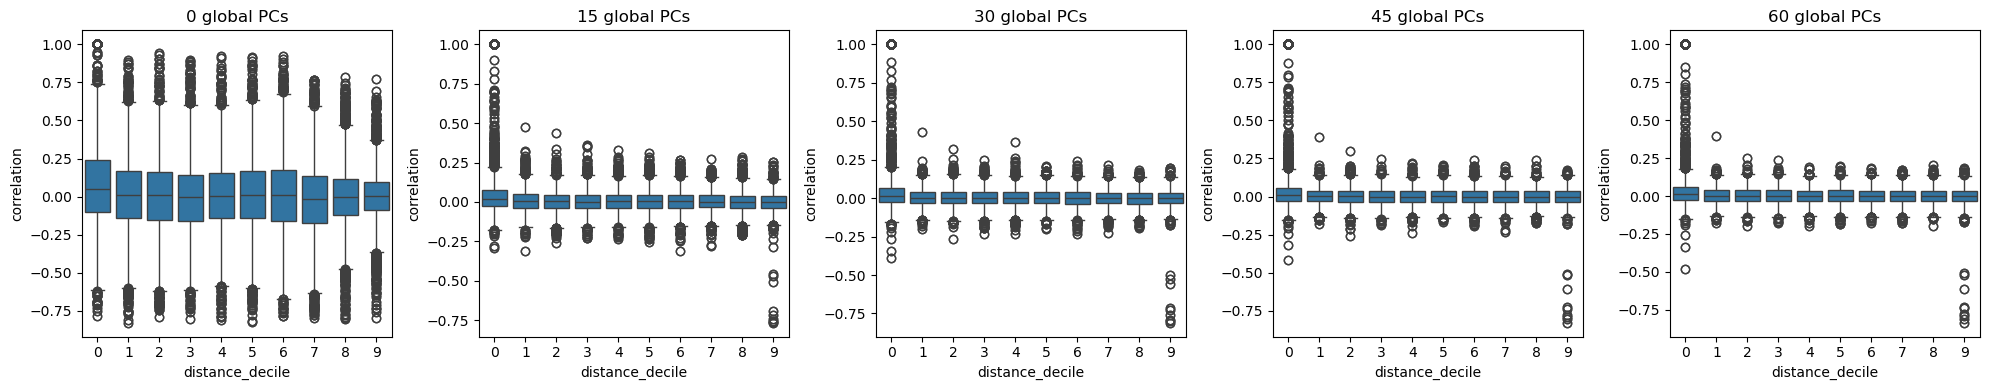

In [83]:
# boxplots plots by increaseing pc factor count

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axes[i].set_title(f'{15*i} global PCs')

    # get corr with this many peerspeer_covariates_df
    sub_exp = two_part_residualize(expression_df, base_covariates_df, pc_covariates_df.iloc[:, :15*i])
    sub_corr = sub_exp.loc[selected_chr_gene_ids].T.corr(method='spearman')
    distance_split_corr_df = pd.DataFrame([pd.Series(sub_corr.values[decile_df==i], name=i) for i in range(10)]).T.melt(var_name='distance_decile', value_name='correlation')
    sns.boxplot(distance_split_corr_df, y='correlation', x='distance_decile', ax=axes[i])

fig.tight_layout()

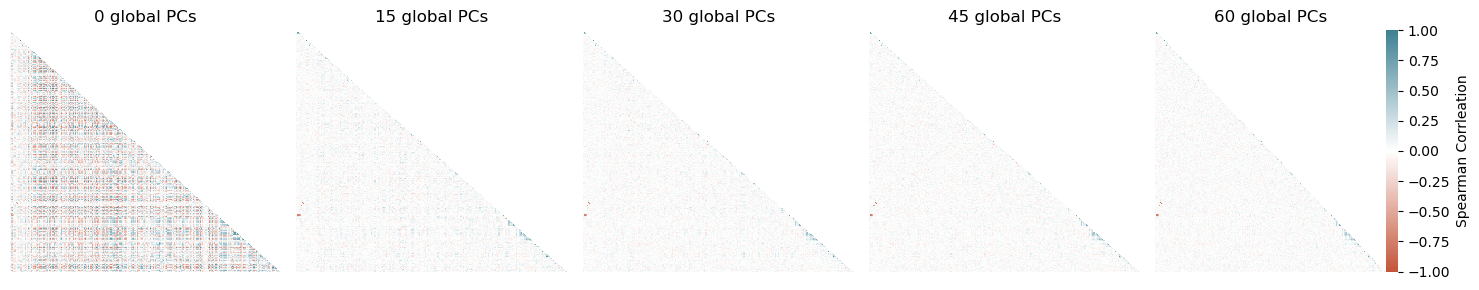

In [79]:
# correlation plots by increaseing global pc factor count

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].set_title(f'{15*i} global PCs')

    # get corr with this many global pcs residualized
    sub_exp = two_part_residualize(expression_df, base_covariates_df, pc_covariates_df.iloc[:, :15*i])
    sub_corr = sub_exp.loc[selected_chr_gene_ids].T.corr(method='spearman')
    plot_heatmap_corr(sub_corr, axes[i], cbar=True if i==4 else False)


fig.tight_layout()

Suggested that maybe I need to do some pre-filtering to determine only variable genes to include in global pcs. This maybe isn't worth the time

## PCs vs PEERs
* at what point do global pcs and peers start removing local structure?

In [104]:
def get_frac_sig_at_decile(residual_pvalue, short_decile_cutoff=1, long_decile_cutoff=8):
      fraction_close_sig = []
      fraction_far_sig = []

      # signifigant corrs along the diagonal or 1-2 away
      #close_pvals = np.concatenate([np.diagonal(peer_residual_pvalue, i) for i in range(1, 3, 1)])

      # sig corrs by decile
      close_pvals = residual_pvalue[decile_df<short_decile_cutoff]
      fraction_close_sig = sum(close_pvals < (.05/total_pairs))/len(close_pvals)

      # signifigant corrs off the diagonal
      #far_pvals = peer_residual_pvalue[np.triu_indices(len(peer_residual_pvalue), k=3)]

      # sig corrs by decile
      far_pvals = residual_pvalue[decile_df>long_decile_cutoff]
      fraction_far_sig = ((far_pvals < (.05/total_pairs))/len(far_pvals)).sum()

      return fraction_close_sig, fraction_far_sig

def compare_peer_pc(expression_df, base_covariates_df, pc_covariates_df, peer_covariates_df, use_mask=False, mask=None):

   fraction_close_sig_pc = []
   fraction_far_sig_pc = []

   fraction_close_sig_peer = []
   fraction_far_sig_peer = []

   for i in range(60):
      # expression residualized with some pcs
      sub_exp = two_part_residualize(expression_df, base_covariates_df, pc_covariates_df.iloc[:, :i])
      pc_residual_corr, pc_residual_pvalue = spearmanr(sub_exp.loc[selected_chr_gene_ids], axis=1)
      np.fill_diagonal(pc_residual_pvalue, 1)
      if use_mask:
         pc_residual_pvalue = np.where(mask, 1, pc_residual_pvalue)

      fraction_close_sig, fraction_far_sig = get_frac_sig_at_decile(pc_residual_pvalue)

      fraction_close_sig_pc.append(fraction_close_sig)
      fraction_far_sig_pc.append(fraction_far_sig)

      # expression residualized with some peers
      sub_exp = two_part_residualize(expression_df, base_covariates_df, peer_covariates_df.iloc[:, :i])
      peer_residual_corr, peer_residual_pvalue = spearmanr(sub_exp.loc[selected_chr_gene_ids], axis=1)
      np.fill_diagonal(peer_residual_pvalue, 1)

      if use_mask:
         peer_residual_pvalue = np.where(mask, 1, peer_residual_pvalue)

      fraction_close_sig, fraction_far_sig = get_frac_sig_at_decile(peer_residual_pvalue)
      
      fraction_close_sig_peer.append(fraction_close_sig)
      fraction_far_sig_peer.append(fraction_far_sig)

   if use_mask:
      fraction_corr_sig_df = pd.DataFrame({'(mask) PC: short-range correlations':fraction_close_sig_pc, 
                                     '(mask) PC: long-range correlations':fraction_far_sig_pc, 
                                     '(mask) PEER: short-range correlations':fraction_close_sig_peer, 
                                     '(mask) PEER: long-range correlations':fraction_far_sig_peer})

   else:
      fraction_corr_sig_df = pd.DataFrame({'PC: short-range correlations':fraction_close_sig_pc, 
                                     'PC: long-range correlations':fraction_far_sig_pc, 
                                     'PEER: short-range correlations':fraction_close_sig_peer, 
                                     'PEER: long-range correlations':fraction_far_sig_peer})
   return fraction_corr_sig_df 


fraction_corr_sig = compare_peer_pc(expression_df, base_covariates_df, pc_covariates_df, peer_covariates_df)
fraction_corr_sig_masked = compare_peer_pc(expression_df, base_covariates_df, pc_covariates_df, peer_covariates_df, use_mask=True, mask=cross_map_df.values)



/local/scratch/klawren/slrmtmp.43332694/ipykernel_5809/2238952078.py:3: UserWarning: The palette list has more values (12) than needed (4), which may not be intended.
  sns.lineplot(fraction_corr_sig, palette=sns.color_palette("Paired"), linestyle='-', ax=ax)
/local/scratch/klawren/slrmtmp.43332694/ipykernel_5809/2238952078.py:4: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(fraction_corr_sig_masked, palette=sns.color_palette("Paired_r"), linestyle='-', ax=ax)


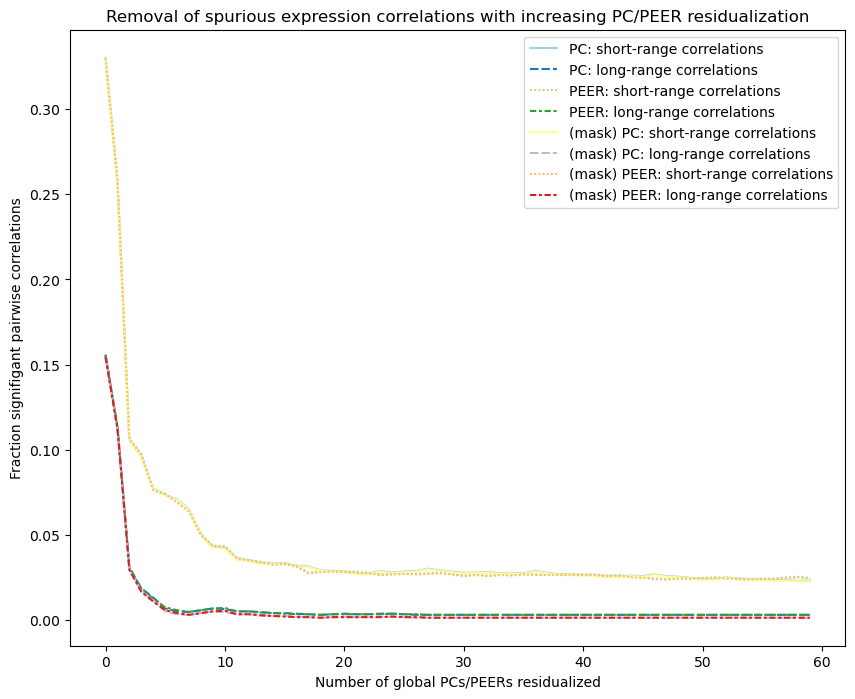

In [108]:
fig, ax = plt.subplots(figsize=(10,8))

sns.lineplot(fraction_corr_sig, palette=sns.color_palette("Paired"), linestyle='-', ax=ax)
sns.lineplot(fraction_corr_sig_masked, palette=sns.color_palette("Paired_r"), linestyle='-', ax=ax)

plt.xlabel('Number of global PCs/PEERs residualized')
plt.ylabel('Fraction signifigant pairwise correlations')

plt.title('Removal of spurious expression correlations with increasing PC/PEER residualization')
plt.show()

# Clustering null
showing that if you shuffle gene order labels, you don't recover any/many clusters

In [7]:
from importlib import reload
import call_clusters

reload(call_clusters)

running call clusters
running call clusters


<module 'call_clusters' from '/home/klawren/oak/pcqtls/workflow/scripts/call_clusters.py'>

In [ ]:
# on just selected_chr takes ~ 7 seconds
# on all chrs takes ~ 10min
real_cluster_df = call_clusters.get_clusters(expression_df_full, final_residual_exp, tissue_id, )

In [ ]:
# randomly resample the dataframe to shuffle the gene locations
# reasign the same 'gene_ids' to match the expression df
shuffled_expression = final_residual_exp.sample(len(final_residual_exp))
shuffled_expression.index = final_residual_exp.index
null_cluster_df = call_clusters.get_clusters(expression_df_full, shuffled_expression, tissue_id)


# cluster density on per chrom basis
cluster_density_null = []
cluster_density = []
for i in np.arange(1,23,1):
    chr_gene_ids = expression_df_full[expression_df_full['#chr'] == f'chr{i}']['gene_id']
    cluster_density_null.append(null_cluster_df[null_cluster_df['Chromosome'] == i]['N_genes'].sum()/len(chr_gene_ids))
    cluster_density.append(real_cluster_df[real_cluster_df['Chromosome'] == i]['N_genes'].sum()/len(chr_gene_ids))

In [ ]:
# combine into a df an plot
cluster_density_df = pd.DataFrame({'Data': cluster_density, 'Null':cluster_density_null})

sns.boxplot(cluster_density_df)
plt.xlabel('Dataset')
plt.ylabel('Clusters/gene')
plt.title('Permutation null for cluster calling')

### cluster threshold variation
vary the threshold for calling clusters and see how they change

In [64]:
# just work on chr21
final_residual_exp = two_part_residualize(expression_df, base_covariates_df, peer_covariates_df)
selected_chr_residual_expression = final_residual_exp.loc[selected_chr_gene_ids]
selected_chr_full_expression = expression_df_full[expression_df_full['#chr']==f'chr{chr_num}']

threshold_cluster_trim_dfs = []
threshold_cluster_notrim_dfs = []

cutoff_list = [.5, .1, .125, .15, .175, .2, .25, .275, .3, .325, .35, .375, .4, .45, .5, .7, .9]
for cutoff in cutoff_list:
    threshold_cluster_trim_dfs.append(call_clusters.get_clusters(selected_chr_full_expression, selected_chr_residual_expression, tissue_id, percent_corr_cutoff=cutoff, trim=True))
    threshold_cluster_notrim_dfs.append(call_clusters.get_clusters(selected_chr_full_expression, selected_chr_residual_expression, tissue_id, percent_corr_cutoff=cutoff, trim=False))

Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22
Working on chr1
Working on chr2
Working on chr3
Working on chr4
Working on chr5
Working on chr6
Working on chr7
Working on chr8
Working on chr9
Working on chr10
Working on chr11
Working on chr12
Working on chr13
Working on chr14
Working on chr15
Working on chr16
Working on chr17
Working on chr18
Working on chr19
Working on chr20
Working on chr21
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Working on chr22


In [65]:
# make series for the number of genes and clusters in each
cluster_trim_series = pd.Series([len(threshold_cluster_trim_dfs[i]) for i in range(len(cutoff_list))], index=cutoff_list, name='count')
gene_trim_series = pd.Series([threshold_cluster_trim_dfs[i]['N_genes'].sum() for i in range(len(cutoff_list))], index=cutoff_list, name='count')
cluster_notrim_series = pd.Series([len(threshold_cluster_notrim_dfs[i]) for i in range(len(cutoff_list))], index=cutoff_list, name='count')
gene_notrim_series = pd.Series([threshold_cluster_notrim_dfs[i]['N_genes'].sum() for i in range(len(cutoff_list))], index=cutoff_list, name='count')

# make a df with all the counts for plotting
threshold_df = pd.DataFrame(pd.concat([cluster_trim_series, gene_trim_series, cluster_notrim_series, gene_notrim_series], 
                       keys=[('cluster', 'trim'), ('gene', 'trim'), ('cluster', 'no_trim'), ('gene', 'no_trim')], 
                       names=['data_type', 'trim', 'percent_corr_cutoff']))
threshold_df.reset_index(inplace=True)

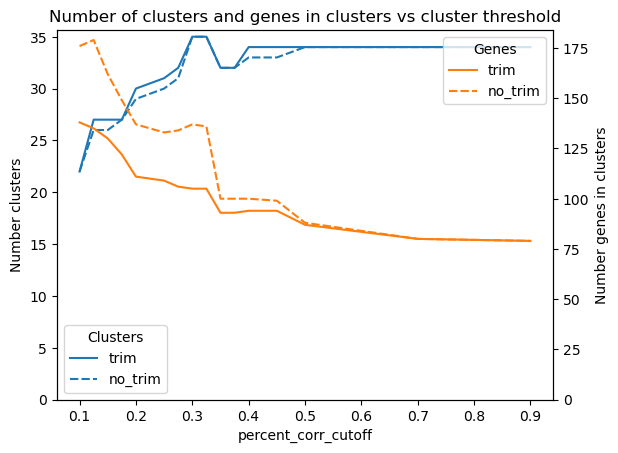

In [66]:
# make the lineplot
# clusters
ax = sns.lineplot(threshold_df[threshold_df['data_type']=='cluster'], x='percent_corr_cutoff', y='count', style='trim')
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel('Number clusters')
ax.legend(title='Clusters')


# genes
ax2 = plt.twinx()
sns.lineplot(threshold_df[threshold_df['data_type']=='gene'], x='percent_corr_cutoff', y='count', style='trim', ax=ax2, color=sns.color_palette()[1])
ax2.set_ylim(0, ax2.get_ylim()[1])
ax2.set_ylabel('Number genes in clusters')
ax2.legend(title='Genes')

ax.set_title('Number of clusters and genes in clusters vs cluster threshold')
plt.show()


In [ ]:
# correlation plots by increaseing cluster threshold

fig, axes = plt.subplots(1, 10, figsize=(100, 10))
for i in range(10):
    axes[i].set_title(f'{.1*(i+1)} % corr cutoff')

    plot_heatmap_corr(final_residual_corr_df, axes[i], cbar=True if i==10 else False)
    # plot clusters at different thresholds
    for idx, row in threshold_cluster_dfs[i].iterrows():
        # location of this cluster in the expression df
        cluster_idxs = selected_chr_expression[selected_chr_expression['gene_id'].isin(row['Transcripts'].split(','))].index.values
        # vertical line part
        axes[i].plot([cluster_idxs[-1]+1,cluster_idxs[-1]+1],[cluster_idxs[0],cluster_idxs[-1]+1],  color='k', linewidth=2)
        axes[i].plot([cluster_idxs[0],cluster_idxs[0]], [cluster_idxs[0],cluster_idxs[-1]+1], color='k', linewidth=2)
        # horizontal line part
        axes[i].plot([cluster_idxs[0],cluster_idxs[-1]+1], [cluster_idxs[-1]+1,cluster_idxs[-1]+1], color='k', linewidth=2)
        axes[i].plot([cluster_idxs[0],cluster_idxs[-1]+1], [cluster_idxs[0],cluster_idxs[0]], color='k', linewidth=2)


fig.tight_layout()
